Kaggle: https://www.kaggle.com/cdeotte/dog-autoencoder

## Importando librerías a usar

In [1]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import os, gc, zipfile
import numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

2022-02-17 11:13:27.312865: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-17 11:13:27.312886: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Importando y procesando todas las imagenes

Descargamos y descomprimimos el zip automáticamente, esto puede tardar algo de tiempo.

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download&confirm=t"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [3]:
file_id = '1xZM7b8Jqq9Wu0GdpGYI8wym8z4vG0789'
destination = 'datasets/multilayer/all_dogs.zip'
download_file_from_google_drive(file_id, destination)

Unzipping...

/home/german/ML/FeatureLearningML/lib/python3.9/site-packages/google_drive_downloader/google_drive_downloader.py:78: UserWarning: Ignoring `unzip` since "1xZM7b8Jqq9Wu0GdpGYI8wym8z4vG0789" does not look like a valid zip file
  warnings.warn('Ignoring `unzip` since "{}" does not look like a valid zip file'.format(file_id))


In [2]:
file_id = '1Wrr6qZA1Tr6r9edNL2nSxnwopMW1n6pR'
destination = 'datasets/multilayer/thumbnails128x128.zip'
download_file_from_google_drive(file_id, destination)

Unzipping...

/home/german/ML/FeatureLearningML/lib/python3.9/site-packages/google_drive_downloader/google_drive_downloader.py:78: UserWarning: Ignoring `unzip` since "1Wrr6qZA1Tr6r9edNL2nSxnwopMW1n6pR" does not look like a valid zip file
  warnings.warn('Ignoring `unzip` since "{}" does not look like a valid zip file'.format(file_id))


In [2]:
# Ejemplo de imágenes
PATH = './datasets/multilayer/all-dogs/'
IMAGES = os.listdir(PATH)
print('There are', len(IMAGES), 'images. Here are 5 example filesnames:')
print(IMAGES[:5])

There are 20579 images. Here are 5 example filesnames:
['n02085620_10074.jpg', 'n02085620_10131.jpg', 'n02085620_10621.jpg', 'n02085620_1073.jpg', 'n02085620_10976.jpg']


Vamos a recortar aleatoriamente las 20.000 imágenes originales y hacer 500.000 nuevas imágenes de entrenamiento.

In [3]:
BATCH_SIZE = 10; EPOCHS = 10
train_datagen = ImageDataGenerator(rescale = 1. / 255)
train_batches = train_datagen.flow_from_directory('datasets/multilayer/',
        target_size = (64, 64), shuffle = True, class_mode = 'input', batch_size = BATCH_SIZE)

Found 20579 images belonging to 2 classes.


# 1. Construir el autoencoder

In [4]:
# Codificar
input_img = Input(shape = (64, 64, 3))  
x = Conv2D(48, (3, 3), activation = 'relu', padding = 'same')(input_img)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(96, (3, 3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(192, (3, 3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
encoded = Conv2D(32, (1, 1), activation = 'relu', padding = 'same')(x)

# Espacio latente
latentSize = (8,8,32)

# Decodificar
direct_input = Input(shape = latentSize)
x = Conv2D(192, (1, 1), activation = 'relu', padding = 'same')(direct_input)
x = UpSampling2D((2, 2))(x)
x = Conv2D(192, (3, 3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(96, (3, 3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation = 'relu', padding = 'same')(x)
decoded = Conv2D(3, (3, 3), activation = 'sigmoid', padding = 'same')(x)

# Compilar
encoder = Model(input_img, encoded)
decoder = Model(direct_input, decoded)
autoencoder = Model(input_img, decoder(encoded))

autoencoder.compile(optimizer = 'Adam', loss = 'binary_crossentropy')

# 2. Entrenar el autoencoder

Es un proceso lento, puede tardar alrededor de 50 minutos.

In [5]:
history = autoencoder.fit(train_batches,
        steps_per_epoch = train_batches.samples // BATCH_SIZE,
        epochs = EPOCHS, verbose = 2)

Epoch 1/10
2057/2057 - 276s - loss: 0.5599 - 276s/epoch - 134ms/step
Epoch 2/10
2057/2057 - 270s - loss: 0.5497 - 270s/epoch - 131ms/step
Epoch 3/10
2057/2057 - 269s - loss: 0.5479 - 269s/epoch - 131ms/step
Epoch 4/10
2057/2057 - 268s - loss: 0.5467 - 268s/epoch - 130ms/step
Epoch 5/10
2057/2057 - 269s - loss: 0.5460 - 269s/epoch - 131ms/step
Epoch 6/10
2057/2057 - 276s - loss: 0.5453 - 276s/epoch - 134ms/step
Epoch 7/10
2057/2057 - 279s - loss: 0.5450 - 279s/epoch - 135ms/step
Epoch 8/10
2057/2057 - 273s - loss: 0.5447 - 273s/epoch - 133ms/step
Epoch 9/10
2057/2057 - 272s - loss: 0.5443 - 272s/epoch - 132ms/step
Epoch 10/10
2057/2057 - 269s - loss: 0.5442 - 269s/epoch - 131ms/step


# 3. Ver la reconstrucción

Nuestro codificador trabaja mapeando imagenes desde un espacio dimensional de 12288(64 x64 x3) a un espacio dimensional de 2048 (imagen latente). Esto es un ratio de compresión x6. Y nuestro decodificador trabaja mapeando nuestra imagen latente hacía atras hasta el espacio dimensional de 12288.

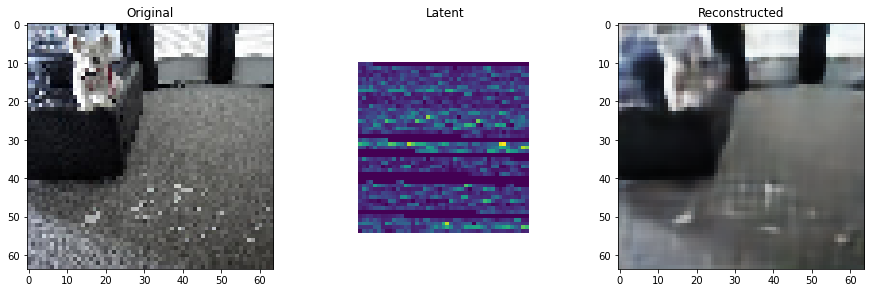

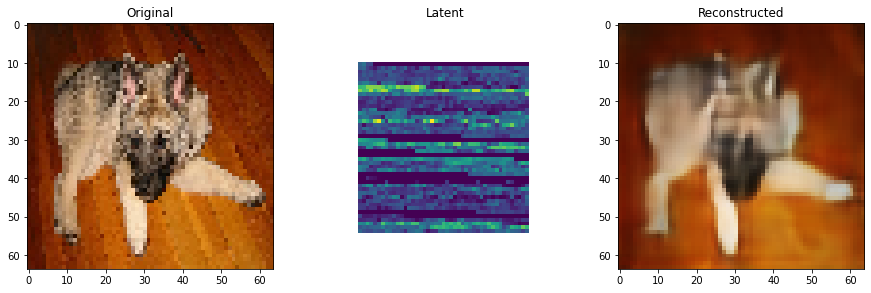

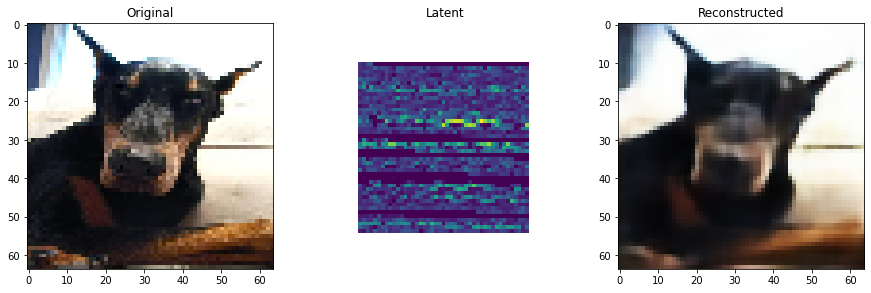

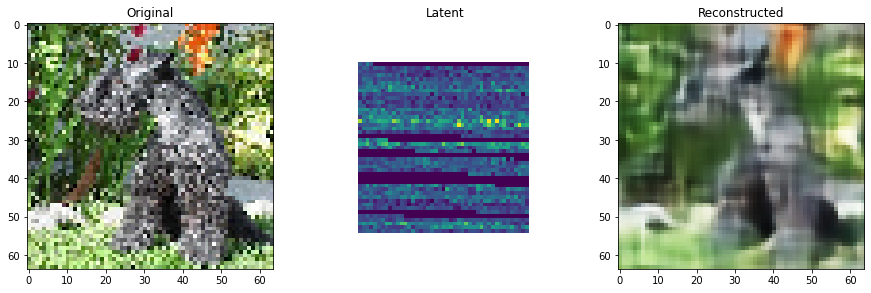

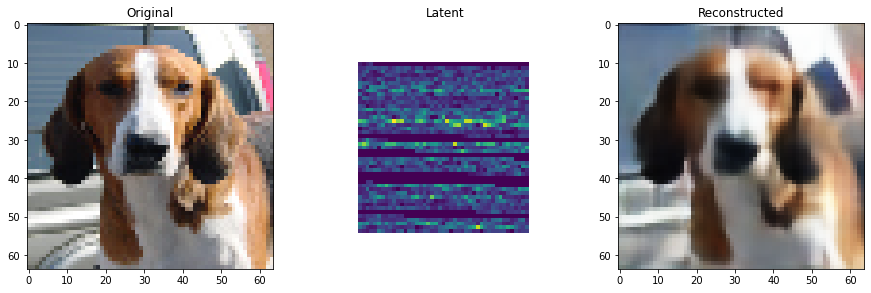

In [6]:
images = next(iter(train_batches))[0]
for i in range(5):

    plt.figure(figsize = (15, 5))
    plt.subplot(1, 3, 1)
    
    # Imagen original
    orig = images[i, :, :, :].reshape((-1, 64, 64, 3))
    img = Image.fromarray( (255 * orig).astype('uint8').reshape((64, 64, 3)))
    plt.title('Original')
    plt.imshow(img)

    # Imagen latente
    latent_img = encoder.predict(orig)
    mx = np.max(latent_img[0])
    mn = np.min(latent_img[0])
    latent_flat = ((latent_img[0] - mn) * 255/(mx - mn)).flatten(order = 'F')
    img = Image.fromarray(latent_flat[:2025].astype('uint8').reshape((45, 45)), mode = 'L') 
    plt.subplot(1, 3, 2)
    plt.title('Latent')
    plt.xlim((-10, 55))
    plt.ylim((-10, 55))
    plt.axis('off')
    plt.imshow(img)

    # Imagen reconstruida
    decoded_imgs = decoder.predict(latent_img[0].reshape((-1, latentSize[0], latentSize[1], latentSize[2])))
    img = Image.fromarray( (255 * decoded_imgs[0]).astype('uint8').reshape((64, 64, 3)))
    plt.subplot(1, 3, 3)
    plt.title('Reconstructed')
    plt.imshow(img)
    
    plt.show()

# 4. Generación de perros

In [7]:
# Genera 1000 imágenes recortadas
x = np.random.choice(np.arange(20000), 10000)
images = np.zeros((10000, 64, 64, 3))
for i in range(len(x)):
    img = Image.open(PATH + IMAGES[x[i]])
    img = img.resize((100, int(img.size[1] / (img.size[0] / 100))), Image.ANTIALIAS)
    img = img.crop((18, 0, 82, 64))
    images[i, :, :, :] = np.asarray(img).astype('float32') / 255.
        
# Calcula el elipsoide a partir de 1000 imágenes     
encoded_imgs = encoder.predict(images)
sz = latentSize[0] * latentSize[1] * latentSize[2]
encoded_imgs = encoded_imgs.reshape((-1, sz))
mm = np.mean(encoded_imgs, axis = 0)
ss = np.cov(encoded_imgs, rowvar = False)

# Genera 9 imágenes random de perros
generated = np.random.multivariate_normal(mm,ss,9)
generated = generated.reshape((-1,latentSize[0],latentSize[1],latentSize[2]))

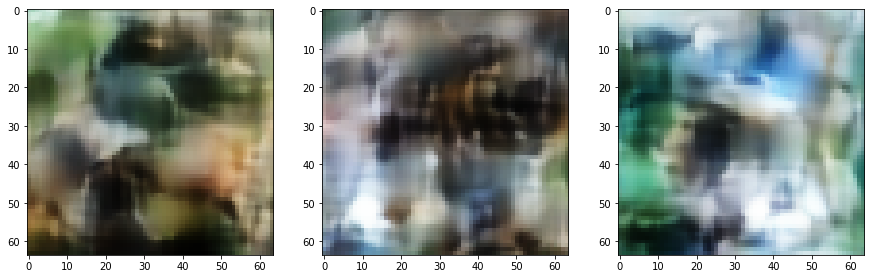

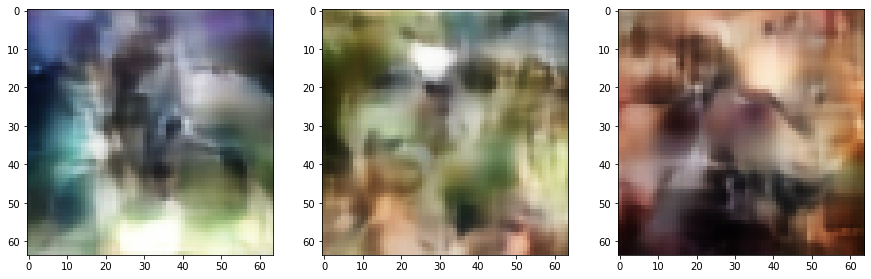

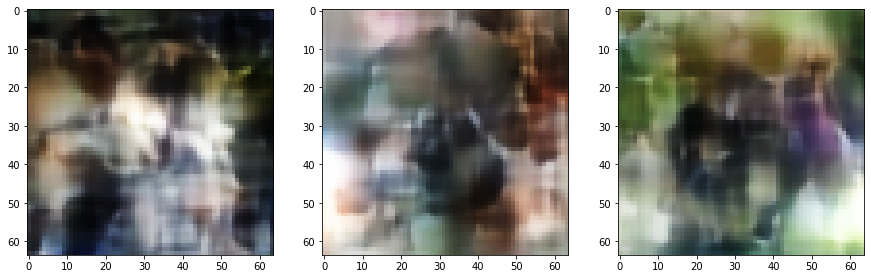

In [8]:
# Muestra esas 9 imágenes
for k in range(3):
    plt.figure(figsize = (15, 5))
    plt.subplot(1, 3, 1)
    decoded_imgs = decoder.predict(generated[k * 3].reshape((-1, latentSize[0], latentSize[1], latentSize[2])))
    img = Image.fromarray( (255 * decoded_imgs[0]).astype('uint8').reshape((64, 64, 3)))
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    decoded_imgs = decoder.predict(generated[k * 3 + 1].reshape((-1, latentSize[0], latentSize[1], latentSize[2])))
    img = Image.fromarray( (255 * decoded_imgs[0]).astype('uint8').reshape((64, 64, 3)))
    plt.imshow(img)
    plt.subplot(1, 3, 3)
    decoded_imgs = decoder.predict(generated[k * 3 + 2].reshape((-1, latentSize[0], latentSize[1], latentSize[2])))
    img = Image.fromarray( (255 * decoded_imgs[0]).astype('uint8').reshape((64, 64, 3)))
    plt.imshow(img)
    plt.show()

# 5. Generar mejores perros

Las imágenes de perros generadas no son muy reconocibles. En vez de escoger puntos randoms en el espacio latente, vamos a escoger puntos cercanos a las imágenes de entrenamiento.

In [15]:
# Distancia a moverse desde las imagenes de entrenamiento existentes
beta = 0.1

# Genera 9 imágenes random de perros
generated = np.random.multivariate_normal(mm, ss, 9)
generated = beta * generated + (1 - beta) * encoded_imgs[:9]

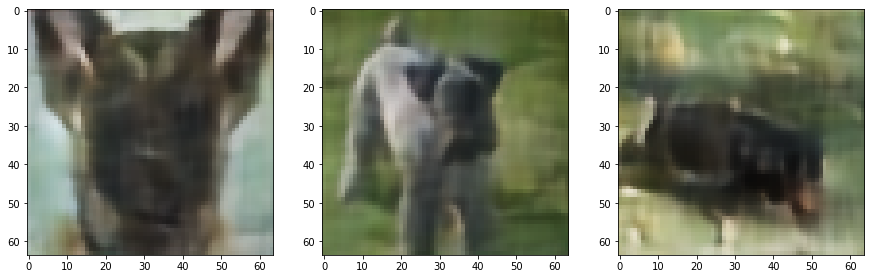

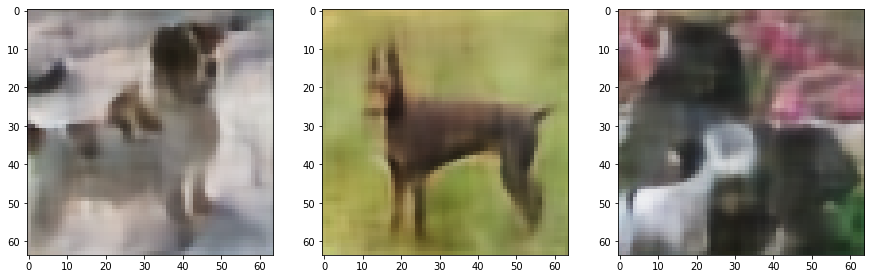

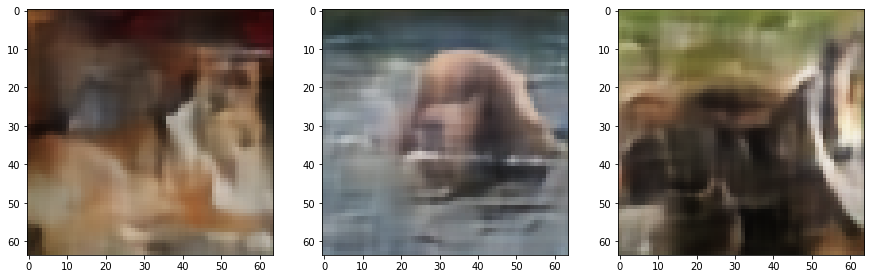

In [16]:
# Muestra esas 9 imágenes
for k in range(3):
    plt.figure(figsize = (15, 5))
    plt.subplot(1, 3, 1)
    decoded_imgs = decoder.predict(generated[k * 3].reshape((-1, latentSize[0], latentSize[1], latentSize[2])))
    img = Image.fromarray( (255 * decoded_imgs[0]).astype('uint8').reshape((64, 64, 3)))
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    decoded_imgs = decoder.predict(generated[k * 3 + 1].reshape((-1, latentSize[0], latentSize[1], latentSize[2])))
    img = Image.fromarray( (255 * decoded_imgs[0]).astype('uint8').reshape((64, 64, 3)))
    plt.imshow(img)
    plt.subplot(1,3,3)
    decoded_imgs = decoder.predict(generated[k * 3 + 2].reshape((-1, latentSize[0], latentSize[1], latentSize[2])))
    img = Image.fromarray( (255 * decoded_imgs[0]).astype('uint8').reshape((64, 64, 3)))
    plt.imshow(img)
    plt.show()

# 6. Resultados

Se puede visualizar la calidad del autoencoder obtenido pidiendole que genere una cantidad de imagenes totalmente nuevas. 

In [11]:
beta = 0.1

# Genera 100 imagenes de perros random
generated = np.random.multivariate_normal(mm, ss, 10000)
encoded_imgs = beta * generated + (1 - beta) * encoded_imgs
decoded_imgs = decoder.predict(encoded_imgs.reshape((-1, latentSize[0], latentSize[1], latentSize[2])))
decoded_imgs.shape

(10000, 64, 64, 3)

In [12]:
# Se guarda en un archivo zip llamado 'images.zip'
z = zipfile.PyZipFile('images.zip', mode = 'w')
for k in range(100):
    img = Image.fromarray( (255 * decoded_imgs[k]).astype('uint8').reshape((64, 64, 3)))   
    f = str(k) + '.png'
    img.save(f, 'PNG'); z.write(f); os.remove(f)
z.close()